In [1]:
import os
import re
import ast
from tqdm import tqdm
import pickle
import numpy as np
import pandas as pd
import netwulf as nw
import networkx as nx
from scipy import stats as st
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx.algorithms.community as nx_comm

In [2]:
# df = pd.read_csv('Characters.csv')
# names = df['name'].values

In [4]:
df_texts = pd.read_csv('descriptions.csv', sep=';')
texts = df_texts['description'].values
names = df_texts['name'].values
hyper_refs = df_texts['referrals']
properties_list = []
for prop in df_texts['properties']:
    properties_list.append(ast.literal_eval(prop))

In [4]:
adjacency_matrix = np.zeros((len(names), len(names)))
names_all = {name: [name] for name in names}
# Assuming a clean text with only lower case words, no punctuation
for i, text in tqdm(enumerate(texts)):
    # word_array = np.array(text.split(' '))
    counts = []
    for real_name in names:
        count = 0
        for nick_name in names_all[real_name]:
            findall = re.findall(nick_name, text)
            text = re.sub(nick_name, '', text)
            count += len(findall)
        counts.append(count)
    # counts = np.array(counts)
    # The row is the node from which the edge comes and the column is thus the receiving node
    # adjacency_matrix[i] += np.array(counts)
    # adjacency_matrix[:, i] += counts.T

958it [00:36, 25.99it/s]


In [5]:
adjacency_matrix_compare = np.zeros((len(names), len(names)))
names_all = {name: [name] for name in names}
# Assuming a clean text with only lower case words, no punctuation
for i, text in tqdm(enumerate(hyper_refs)):
    # word_array = np.array(text.split(' '))
    counts = []
    for real_name in names:
        count = 0
        for nick_name in names_all[real_name]:
            count += len(re.findall(nick_name, str(text)))
        counts.append(count)
    # counts = np.array(counts)
    # The row is the node from which the edge comes and the column is thus the receiving node
    adjacency_matrix_compare[i] += np.array(counts)

958it [00:36, 26.10it/s]


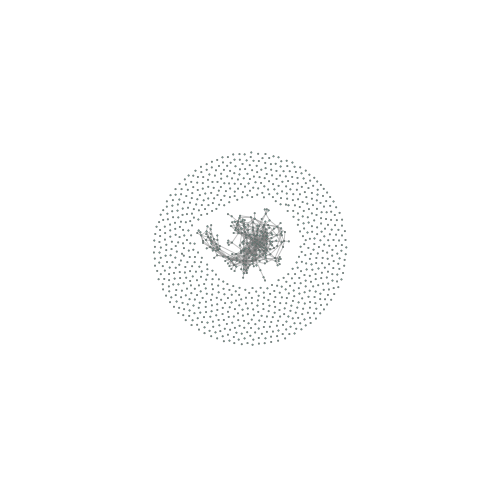

In [6]:
adjacency_matrix += (adjacency_matrix_compare == 1) * (adjacency_matrix == 0)
G = nx.from_numpy_matrix(adjacency_matrix)
network, config = nw.visualize(G, config={'zoom':0.6, 'node charge':-15, 'node gravity': 0.7})
nw.save("Graph.json", network, config, G)

In [11]:
len(G.nodes)

958

In [14]:
stylized_network, config, G = nw.load("Graph.json")

This next part does some basic analysis

Maximum degree: 68, Minimum degree: 0
Assortivity coefficient r = 0.007


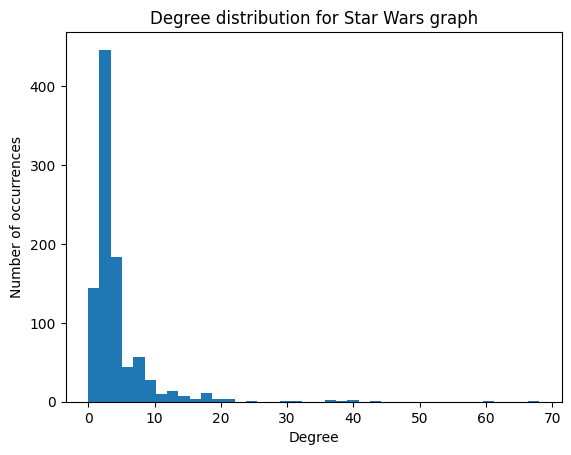

In [29]:
import matplotlib.pyplot as plt
degrees = [d for _, d in G.degree()]

print(f'Maximum degree: {max(degrees)}, Minimum degree: {min(degrees)}')
r = nx.degree_assortativity_coefficient(G)
print(f"Assortivity coefficient r = {r:.3f}")
plt.hist(degrees, bins=40)
plt.title('Degree distribution for Star Wars graph')
plt.ylabel('Number of occurrences')
plt.xlabel('Degree')
plt.savefig('DegreeDistribution.png')
plt.show()

In [21]:
connected_largest = sorted(nx.algorithms.connected_components(G), key=len, reverse=True)[0]
G_sub = nx.Graph.subgraph(G, connected_largest)
avg_shortest_sub = nx.average_shortest_path_length(G_sub)
print(f'Average shortest path in the largest connected component is {round(avg_shortest_sub, 2)}')

Average shortest path in the largest connected component is 4.63


In [ ]:
fig, ax = nw.draw_netwulf(network)
plt.savefig('StarWarsGraphNaked')

In [5]:
# Compute the communities
partition = nx_comm.louvain_communities(G)
# Create a list of the number of nodes in each community
sizes = [len(c) for c in partition]
print(
    f'The average community size is {round(np.mean(sizes), 2)}, with a standard deviation of {round(np.std(sizes), 2)}. The largest is of size {np.max(sizes)} and the smallest {np.min(sizes)}')

NameError: name 'G' is not defined

In [ ]:
# Create a np array of nodes to use for finding their positions in the graph's list
G_where = np.array(G.nodes)
# Initialize the array for colours and the values for which to colour
degreeColor = np.empty(len(G_where), dtype=object)
valueToPlot = np.log10(sizes)
# we rescale the colours to be in the RGB format (0 to 255 for three colours)
valueToPlotRescaled = 255*(valueToPlot - np.min(valueToPlot))/np.max(valueToPlot)

for size, c in zip(sizes, partition):
    for node in c:
        # Use the size to set the colour
        color = '#%02x%02x%02x' % (int(size), 0, 50)
        degreeColor[np.where(G_where == node)] = color
# zip it up into a dictionary and set it as node attribute
dictionaryColor = dict(zip(list(G.nodes), degreeColor))
nx.set_node_attributes(G, dictionaryColor, 'group')

In [ ]:
def modularity(G, communities):
    m = G.number_of_edges()
    q = .0
    for c in communities:
        lc = G.subgraph(c).number_of_edges()
        kc = sum(G.degree(n) for n in c)
        q += lc / m - (kc / (2 * m)) ** 2
    return q

modularity_from_current_communities = modularity(G, partition)